In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(rc={"figure.figsize": (16, 12)})
sns.set_style('white')
sns.set_style('ticks')
sns.set_context("paper")

import numpy as np
import pymc3 as pm
import theano.tensor as tt 
import scipy
from scipy import stats
# from pymc3.distributions.timeseries import EulerMaruyama

/Users/andrew/anaconda/envs/ml-env/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%qtconsole

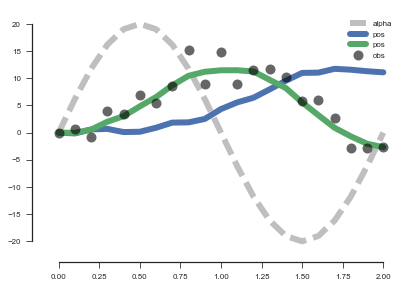

In [3]:
T = 2
dt = 0.1
nsteps = T/dt

amplitude = 20
phi  = 0.0
f = 0.5

time = np.arange(0, T+dt, dt)

def control(t, amplitude, phi=0): 
    return(amplitude * np.sin(2 * np.pi * f * t + phi))

alpha = control(time, amplitude=20, phi=0.0)

nsteps = int(T/dt)

x = np.zeros((nsteps+1, 2))
y = np.zeros((nsteps+1, 1))

mvnorm = stats.multivariate_normal
covar = np.diag([0.2, 0.1])
sigma_y = 1.7

x[0] = np.zeros(2)

A = np.array([[1, dt], [0, 1]])
B = np.array([0.5 * dt**2, dt])

# x[,0] is the position
# x[, 1] is the velcocity

# This is written without matrix notation
# for t in range(1, nsteps):
#     x[t, 0] = x[t-1, 0] + Δt*x[t-1, 1] + 0.5 * Δt**2 * α[t-1]
#     x[t, 1] = x[t-1, 1] + Δt * α[t-1]

# This is in matrix notation
# x[t] = np.dot(true_A, x[t-1].T) + np.dot(true_B, α[t-1])
# where α[t-1] is the ("known") control input
    

# Generated data
for t in range(1, nsteps+1):
#     x_t = Ax[t-1] + Bu[t-1]
    x[t] = mvnorm.rvs(mean=np.dot(A, x[t-1].T) + np.dot(B, control(dt*(t-1), amplitude, phi=0)),
                      cov=covar, size=1)
#     x[t] = mvnorm.rvs(mean=np.dot(true_A, x[t-1].T) + np.dot(true_B, α[t-1]), cov=Σ, size=1)
#     y is the noisy observation of x[, 1], i.e. velocity
    y[t] = stats.norm.rvs(loc=x[t, 1], scale=sigma_y, size=1)
    

#print(f"True A: \n{true_A}")
#print(f"True B: \n{true_B}")


plt.plot(time, alpha, 'k--', linewidth=6, alpha=0.25, label='alpha')
plt.plot(time, x, linewidth=6, label='pos')

# [plt.plot(time, var) for var in [α, x]]

plt.plot(time, y, '.', markersize=20, color='black', alpha=0.6, label='obs')
sns.despine(offset=10, trim=True)
plt.legend(loc='best')

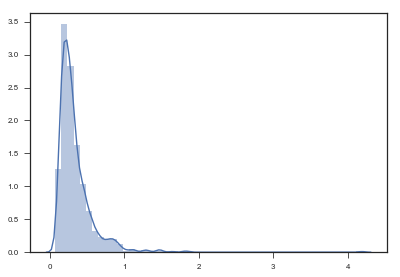

In [4]:
# Better prior for SD? Inverse Gamma seems to work better than Half-Cauchy.

sd_prior = scipy.stats.invgamma.rvs(a=4, loc=0, scale=1, size=1000)
sns.distplot(sd_prior, kde=True);

# fig, ax = plt.subplots(1, 1)
# x = np.linspace(scipy.stats.halfcauchy.ppf(0.01), scipy.stats.halfcauchy.ppf(0.99), 100)
# ax.plot(x, scipy.stats.halfcauchy.pdf(x), 'r-', lw=5, alpha=0.6, label='halfcauchy pdf')

In [6]:
nsteps = len(y)

basic_model=pm.Model()

with basic_model:
    
    pos = np.empty(nsteps, dtype='object')
    vel = np.empty(nsteps, dtype='object')
    
    pos[0]=pm.Normal('pos0', mu=0, sd=2)
    vel[0]=pm.Normal('vel0', mu=0, sd=2)
    
    sd_obs = pm.InverseGamma("sd_obs", alpha=3, beta=2)
    sd_pos = pm.InverseGamma("sd_pos", alpha=4, beta=1)
    sd_vel = pm.InverseGamma("sd_vel", alpha=4, beta=1)
    
    u = control(time, amplitude=20, phi=0.0)

    for t in range(1, nsteps):        
        pos[t] = pm.Normal('pos'+str(t), mu=pos[t-1] + dt*vel[t-1] + 0.5*dt**2 * u[t-1], \
                                sd=sd_pos)
        vel[t] = pm.Normal('vel'+str(t), mu=vel[t-1] + dt*u[t-1], \
                                sd=sd_vel)
        y_obs=pm.Normal("y_obs"+str(t), mu=vel[t], observed=y[t], sd=sd_obs)

In [66]:
with basic_model:
    trace = pm.sample(2000, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -65.026: 100%|██████████| 200000/200000 [01:15<00:00, 2662.17it/s]
Finished [100%]: Average ELBO = -65.228
100%|██████████| 2000/2000 [07:01<00:00,  6.22it/s]


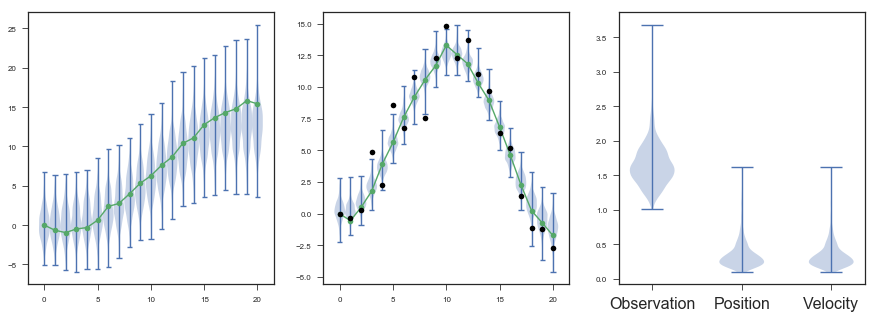

In [67]:
xr=range(nsteps)

# Unpack all the trace for plotting
pos_all=[[atrace['pos'+str(t)] for atrace in trace[1000:]] for t in xr]
vel_all=[[atrace['vel'+str(t)] for atrace in trace[1000:]] for t in xr]
sd_obs_all=[atrace['sd_obs'] for atrace in trace[1000:]]
sd_pos_all=[atrace['sd_pos'] for atrace in trace[1000:]]
sd_vel_all=[atrace['sd_pos'] for atrace in trace[1000:]]

plt.figure( figsize=(15,5))
plt.subplot(1,3,1)
plt.violinplot(pos_all, positions=xr, widths=1.0)
plt.plot(xr, x[:,0], 'o-')

plt.subplot(1,3,2)
plt.violinplot(vel_all, positions=xr, widths=1.0)
plt.plot( x[:,1], 'o-')
plt.plot( y, 'ko')

plt.subplot(1,3,3)
plt.violinplot( [sd_obs_all,sd_pos_all, sd_vel_all] );
plt.xticks([1,2,3], ['Observation', 'Position', 'Velocity'],size=16 );

plt.savefig('inferred.pdf', bbox_inches='tight')

In [69]:
# trying out variational inference:
with basic_model:
    means, sds, elbos = pm.variational.advi(n=100000)

Average ELBO = -63.322: 100%|██████████| 100000/100000 [00:44<00:00, 2234.60it/s]
Finished [100%]: Average ELBO = -63.43


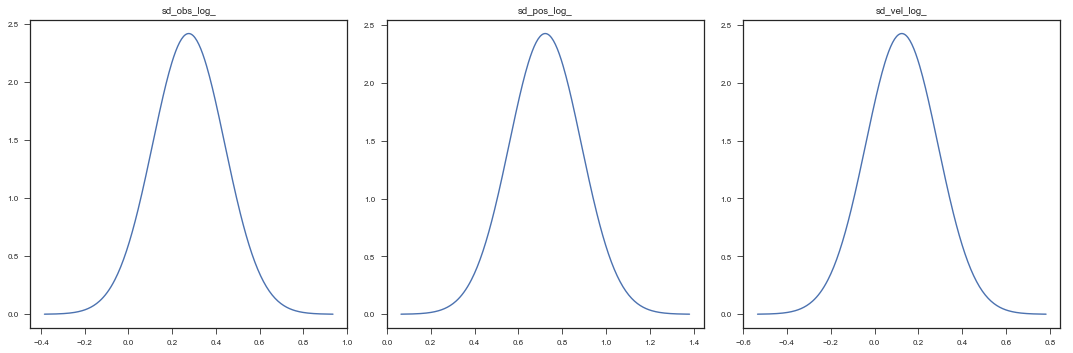

In [75]:
# varnames = means.keys()
varnames = ['sd_obs_log_', 'sd_pos_log_', 'sd_vel_log_']
fig, axs = plt.subplots(ncols=len(varnames), figsize=(15, 5))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
        
fig.tight_layout()